# Quality Control for the Vaisala Air Quality Transmitter (AQT-530)

[CROCUS](https://crocus-urban.org/) utilizes the Vasiala WXT-536 within all Chicago Micronet nodes. <br>
Data are collected at the instrument via [Waggle Plugin Scripts](https://github.com/jrobrien91/waggle-aqt), which incorporate the sensors into the Waggle node. <br>
Data collected at each site are accumulated into daily files via [ingest scripts](https://github.com/CROCUS-Urban/ingests/blob/main/scripts/aqt-ingest.py) 
and hosted on the [CROCUS Thredds Server](https://thredds.crocus-urban.org/thredds/catalog/aqt/neiu-aqt-a1/catalog.html)

In [1]:
import xarray as xr
from xarray.backends import NetCDF4DataStore
import act
import glob

In [2]:
import calmap

In [3]:
import random

In [4]:
import matplotlib.pyplot as plt

In [5]:
import numpy as np
from scipy.stats.mstats import pearsonr

In [6]:
import pandas as pd

In [7]:
from metpy.calc import dewpoint_from_relative_humidity, wet_bulb_temperature
from metpy.units import units

In [33]:
import datetime

## Open All the Files

In [8]:
file_list = sorted(glob.glob("/Users/jrobrien/ANL/Instruments/Vaisala_WXT536/data/wfip3/capecod/*"))

In [9]:
R1output = {'time': [], 'command': [], 'Dn': [], 'Dm': [], 'Dx': [], 'Sn': [], 'Sm': [], 'Sx': []}
R2output = {'time': [], 'command': [], 'Ta': [], 'Ua': [], 'Pa': []}
R5output = {'time': [], 'command': [], 'Th': [], 'Vh': [], 'Vs': [], 'Vr': []}

In [10]:
def wxt_strip(sample, verbose=False):
    inval = ''
    if len(sample) > 2:
        if sample[1] == "0R1":
            if len(sample) > 7:
                try:
                    inval = [True for var in sample[2:] if var.split('=')[:-1][0] not in R1output.keys()]
                except:
                    inval = True
                if not inval:
                    try:
                        nlist = [(var.split('=')[:-1][0], float(var.split('=')[1][0:-1])) for var in sample[2:]]
                        for i in range(len(nlist)):
                            R1output[nlist[i][0]].append(nlist[i][1])
                        R1output['time'].append(pd.to_datetime(sample[0]))
                        R1output['command'].append("0R1")
                        if len(R1output['Dn']) != len(R1output['Sx']):
                            print(sample)
                    except:
                        if verbose == True:
                            print('Error: ', sample)
        if sample[1] == '0R2':
            if len(sample) > 4:
                try:
                    inval = [True for var in sample[2:] if var.split('=')[:-1][0] not in R2output.keys()]
                except:
                    inval = True
                if not inval:
                    try:
                        nlist = [(var.split('=')[:-1][0], float(var.split('=')[1][0:-1])) for var in sample[2:]]
                        for i in range(len(nlist)):
                            R2output[nlist[i][0]].append(nlist[i][1])
                        R2output['time'].append(pd.to_datetime(sample[0]))
                        R2output['command'].append("0R2")
                    except:
                        if verbose == True:
                            print('Error: ', sample)
        if sample[1] == '0R5':
            if len(sample) > 5:
                try:
                    inval = [True for var in sample[2:] if var.split('=')[:-1][0] not in R5output.keys()]
                except:
                    inval = True
                if not inval:
                    try:
                        nlist = [(var.split('=')[:-1][0], float(var.split('=')[1][0:-1])) for var in sample[2:]]
                        for i in range(len(nlist)):
                            R5output[nlist[i][0]].append(nlist[i][1])
                        R5output['time'].append(pd.to_datetime(sample[0]))
                        R5output['command'].append("0R5")
                    except:
                        if verbose == True:
                            print('Error: ', sample)

In [11]:
%%time
for file in file_list:
    with open(file, 'r') as nfile:
        lines = nfile.readlines()
        for sample in lines:
            wxt_strip(sample.strip().split(','))

CPU times: user 2min 6s, sys: 254 ms, total: 2min 6s
Wall time: 2min 7s


In [12]:
for key in R1output:
    print(key, len(R1output[key]))

time 639141
command 639141
Dn 639141
Dm 639141
Dx 639141
Sn 639141
Sm 639141
Sx 639141


In [13]:
for key in R2output:
    print(key, len(R2output[key]))

time 53273
command 53273
Ta 53273
Ua 53273
Pa 53273


In [14]:
for key in R5output:
    print(key, len(R5output[key]))

time 211936
command 211936
Th 211936
Vh 211936
Vs 211936
Vr 211936


In [15]:
pdR1 = pd.DataFrame.from_dict(R1output)
pdR2 = pd.DataFrame.from_dict(R2output)
pdR5 = pd.DataFrame.from_dict(R5output)

In [16]:
# Combine all the dataframes into one
pd_com = pd.concat([pdR1,pdR2, pdR5], axis=0, ignore_index=True)

In [17]:
# set time as the index
pd_com = pd_com.set_index('time').sort_index()

In [18]:
pd_com

,command,Dn,Dm,Dx,Sn,Sm,Sx,Ta,Ua,Pa,Th,Vh,Vs,Vr
time,,,,,,,,,,,,,,
2023-12-23 21:56:02.338386,0R1,160.0,168.0,172.0,1.1,1.3,1.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-23 21:56:07.346788,0R5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,24.0,24.4,3.648
2023-12-23 21:56:08.350029,0R1,193.0,197.0,204.0,0.9,0.9,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-23 21:56:12.338159,0R1,176.0,191.0,207.0,0.8,1.0,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-23 21:56:17.345956,0R1,176.0,181.0,189.0,0.9,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-12 14:00:50.110237,0R1,156.0,171.0,186.0,3.9,4.6,5.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-12 14:00:59.165982,0R2,NaN,NaN,NaN,NaN,NaN,NaN,14.6,91.9,992.5,NaN,NaN,NaN,NaN
2024-04-12 14:01:05.116720,0R1,118.0,144.0,165.0,7.2,7.8,8.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
ds = pd_com.to_xarray()

In [20]:
ds

<xarray.Dataset> Size: 109MB
Dimensions:  (time: 904350)
Coordinates:
  * time     (time) datetime64[ns] 7MB 2023-12-23T21:56:02.338386 ... 2024-04...
Data variables: (12/14)
    command  (time) object 7MB '0R1' '0R5' '0R1' '0R1' ... '0R1' '0R5' '0R1'
    Dn       (time) float64 7MB 160.0 nan 193.0 176.0 ... nan 118.0 nan 117.0
    Dm       (time) float64 7MB 168.0 nan 197.0 191.0 ... nan 144.0 nan 143.0
    Dx       (time) float64 7MB 172.0 nan 204.0 207.0 ... nan 165.0 nan 166.0
    Sn       (time) float64 7MB 1.1 nan 0.9 0.8 0.9 nan ... 3.9 nan 7.2 nan 3.5
    Sm       (time) float64 7MB 1.3 nan 0.9 1.0 1.0 nan ... 4.6 nan 7.8 nan 4.3
    ...       ...
    Ua       (time) float64 7MB nan nan nan nan nan nan ... nan 91.9 nan nan nan
    Pa       (time) float64 7MB nan nan nan nan nan ... nan 992.5 nan nan nan
    Th       (time) float64 7MB nan 15.0 nan nan nan ... nan nan nan 15.6 nan
    Vh       (time) float64 7MB nan 24.0 nan nan nan ... nan nan nan 24.0 nan
    Vs       (time) float64 7MB nan 24.4 nan nan nan ... nan nan nan 24.3 nan
    Vr       (time) float64 7MB nan 3.648 nan nan nan ... nan nan nan 3.647 nan

## Create a display

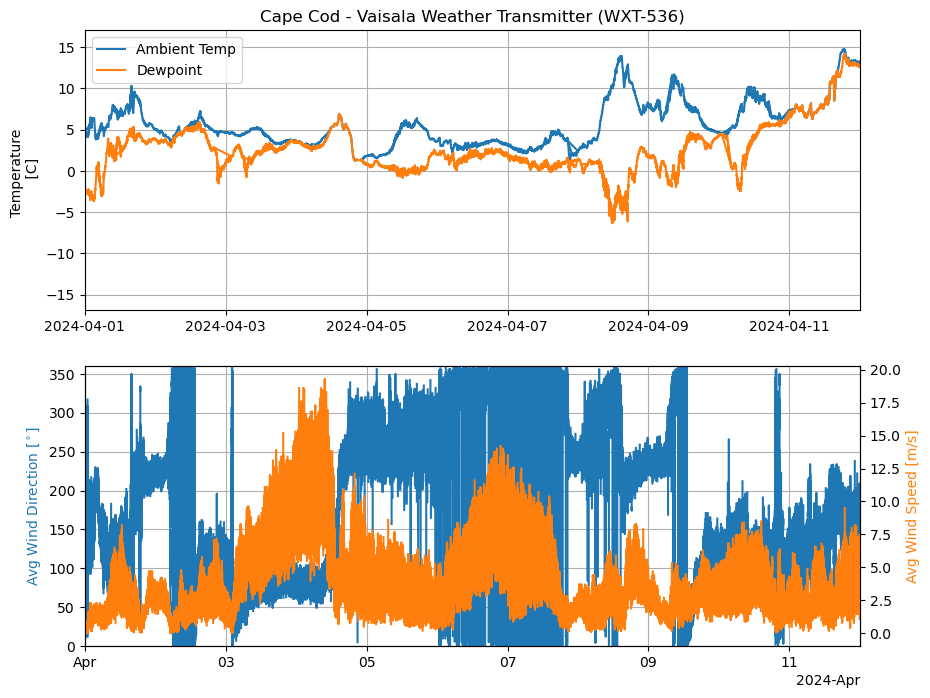

In [57]:
fig, axarr = plt.subplots(2, 1, figsize=[10, 8])
#fig.subplots_adjust(hspace=0.5)

# ------------------
# Calculate dewpoint
# ------------------
dp = dewpoint_from_relative_humidity(np.array(R2output['Ta']) * units.degC, 
                                     np.array(R2output['Ua']) * units.percent)

# --------------------------
# Air & Dewpoint Temperature
# --------------------------
#ds.sel(time=slice("20240401", "20240412")).Ta.plot(ax=axarr[0], label="Ambient Temp", color='tab:orange')
#axB = axarr[0].twinx()
#ds.Ua.plot(ax=axB, label="Humidity", color='tab:green')
axarr[0].plot(R2output['time'], R2output['Ta'], color='tab:blue', label="Ambient Temp")
axarr[0].plot(R2output['time'], dp, color='tab:orange', label="Dewpoint")

#newDate = DATE[0:4] + '/' + DATE[4:6] + '/' + DATE[6:8]

axarr[0].set_title("Cape Cod - Vaisala Weather Transmitter (WXT-536)")
axarr[0].set_ylabel("Temperature \n [C]")
#axarr[0].set_xlabel("Date [Local]")
axarr[0].legend(loc="upper left")
axarr[0].grid(True)
axarr[0].set_xlim([datetime.date(2024, 4, 1), datetime.date(2024, 4, 12)])

# -------------------------
# Wind Direction and Speed
# -------------------------
ax2 = axarr[1].twinx()
ds.sel(time=slice("20240401", "20240412")).Dm.plot(ax=axarr[1], label='Wind Direction', color="tab:blue")
ds.sel(time=slice("20240401", "20240412")).Sm.plot(ax=ax2, label="Wind Speed", color="tab:orange")
axarr[1].set_ylim([0, 360])
axarr[1].grid(True)
axarr[1].set_ylabel(r'Avg Wind Direction [$^\circ$]', color="tab:blue")
ax2.set_ylabel(r"Avg Wind Speed [m/s]", color="tab:orange")
axarr[1].set_xlabel("")
axarr[1].set_xlim([datetime.date(2024, 4, 1), datetime.date(2024, 4, 12)])

plt.savefig('CACO_WXT_14April2024_timeseries.png')